In [1]:
import os
import random

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy, Precision, Recall

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16

import numpy as np
import matplotlib.pyplot as plt

E0000 00:00:1721993218.090649      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D0726 11:26:58.098733388      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0726 11:26:58.098747905      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0726 11:26:58.098751347      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0726 11:26:58.098753851      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0726 11:26:58.098756290      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1721993231.930211      13 service.cc:145] XLA service 0x5c632b7a10c0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721993231.930279      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1721993231.930284      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1721993231.930287      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1721993231.930290      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1721993231.930293      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1721993231.930297      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1721993231.930300      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1721993231.930302      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [3]:
# strategy = tf.distribute.MirroredStrategy()

# Custom F1Score class
### Normal tensorflow F1Score is not supported here like google colab

In [4]:
from tensorflow.keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name='f1score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [5]:
dataset_base_path = '/kaggle/input/book-and-notebook'
db_name = '/kaggle/input/book-and-notebook/dataset_256'

# Hyper Parameters

In [540]:
batch_size = 32
image_size = (256, 256)
learning_rate = 1e-4
lr_decay_factor = 0.09
epochs=50
label_mode = 'int'
seed=42
train_ds_size=3000
val_ds_size=1000

In [541]:
# print('Replicas: ',strategy.num_replicas_in_sync)

# Batch size when using GPU

In [542]:
# batch_size = strategy.num_replicas_in_sync * 8

# Batch size when using TPU

In [543]:
batch_size = strategy.num_replicas_in_sync * 4

# Setting up random seed for deterministic output

In [544]:
tf.random.set_seed(seed)

global_generator = tf.random.Generator.from_seed(seed)
tf.random.set_global_generator(global_generator)

np.random.seed(seed)
random.seed(seed)
AUTOTUNE = tf.data.AUTOTUNE

In [545]:
print(batch_size)

32


# Reading train, validation and test dataset

In [546]:
train_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/train',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=True,
)

val_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/valid',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=False,
)

test_ds = keras.utils.image_dataset_from_directory(
    f'{db_name}/test',
    image_size=image_size,
    batch_size=batch_size,
    label_mode=label_mode,
    shuffle=False,
)


# test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float16), tf.cast(y, tf.uint8)))
# test_ds = test_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))

# Used for plotting
class_names = train_ds.class_names

Found 782 files belonging to 2 classes.
Found 106 files belonging to 2 classes.
Found 160 files belonging to 2 classes.


In [547]:
# # train_ds.map(lambda image, label: image)
# train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float16), tf.cast(y, tf.uint8)))
# val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float16), tf.cast(y, tf.uint8)))
# train_ds = train_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))
# val_ds = val_ds.map(lambda x, y: (x, tf.cast(y, tf.int32)))

# plot function

In [548]:
# def show(ds):
#   for imgs, labels in ds:
#     break
#   info = []
#   for i in range(12):
#     info.append((labels[i], i))
#   info.sort()

#   plt.figure(figsize=(10, 4))
#   # plt.suptitle('Dataset samples', fontsize=20)
#   for i in range(12):
#     plt.subplot(2,6,i+1)
#     plt.imshow(imgs[info[i][1]] / 255)
#     plt.axis('off')
#     plt.title('{}'.format(labels[info[i][1]]))

#   # plt.savefig("./{}.png".format('dataset-samples'), bbox_inches='tight', format='png', dpi=256)
#   plt.show();

def plot_images(dataset, title, n_images=20):
    dataset.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
    dataset_iter = iter(dataset)
    images, labels = next(dataset_iter)
    plt.figure(figsize=(12, 8))
    n_images = min(n_images, len(images))
    for i in range(n_images):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i].numpy()))
        plt.axis("off")
    plt.suptitle(title)
    # plt.savefig("./{}.png".format('dataset-samples'), bbox_inches='tight', format='png', dpi=256)
    plt.show()


# Checking if an image is blackish or not

In [549]:
def is_blackish(image, threshold=80.0):
    # Convert the image to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    
    # Calculate the mean brightness
    mean_brightness = tf.reduce_mean(grayscale_image).numpy()
#     print(mean_brightness)
    # Check if the mean brightness is below the threshold
    return mean_brightness < threshold

# Photometric augmentation functions

In [550]:
def adjust_contrast(image):
    return tf.image.adjust_contrast(image, contrast_factor=1.1)

def adjust_brightness(image):
    return tf.image.adjust_brightness(image, delta=100.0)

def adjust_saturation(image):
    return tf.image.adjust_saturation(image, saturation_factor=2)

def adjust_gamma(image):
    return tf.image.adjust_gamma(image, gamma=1.001)

def adjust_hue(image):
    return tf.image.adjust_hue(image, 0.12)

# Applying photometric functions

In [551]:
def combined_preprocessing(image):
    choice = np.random.choice(['saturation', 'contrast', 'hue', 'gamma'])
    
    if is_blackish(image):
        image = adjust_brightness(image)
#     return image
#     image = adjust_saturation(image)
    
    if choice == 'contrast':
        image = adjust_contrast(image)
    elif choice == 'gamma':
        image = adjust_gamma(image)
    elif choice == 'hue':
        image = adjust_hue(image)
    elif choice == 'saturation':
        image = adjust_saturation(image)
    return image

# Generating geometric augmented images

In [552]:
geodatagen = ImageDataGenerator(rotation_range=45,
        shear_range=0.20,
        zoom_range=0.45,
        horizontal_flip=True,
        fill_mode='nearest')

# Generating photometric augmented images

In [553]:
photodatagen = ImageDataGenerator(
    preprocessing_function=combined_preprocessing,
)

# Generating geometric images

In [554]:
train_generator = geodatagen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
val_generator = geodatagen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)

Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


# Generating photometric images

In [555]:
photo_train_generator = photodatagen.flow_from_directory(
    f'{db_name}/train',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)
photo_val_generator = photodatagen.flow_from_directory(
    f'{db_name}/valid',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary',
    classes=class_names,
    seed=seed,
)

Found 782 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [556]:
def getImgs(gen, n):
    aug_images = []
    aug_labels = []
    for _ in range(n):
        images, labels = next(gen)
        aug_images.extend(images)
        aug_labels.extend(labels)
    
    aug_images = np.array(aug_images)
    aug_labels = np.array(aug_labels)
    return aug_images, aug_labels

# Only geometric augmented images of train data

In [557]:
images, labels = getImgs(train_generator, train_ds_size // batch_size)
new_images = []
for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

# Only geometric augmented images of validation data

In [558]:
images, labels = getImgs(val_generator, val_ds_size // batch_size)
new_images = []

for image in images:
#     if is_blackish(image):
#         image = adjust_brightness(image)
#     image = adjust_saturation(image)
    new_images.append(image)

images = np.array(new_images)
# images = images.astype(np.float16)
labels = labels.astype(np.int32)

aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

# plt.imshow(img)
# plt.show()
del images
del labels

In [559]:
# train_ds = train_ds.filter(lambda x, y: False)
# val_ds = val_ds.filter(lambda x, y: False)

# Merging the geometric augmented images to actual train and validation dataset

In [560]:
train_ds = train_ds.concatenate(aug_train)
val_ds = val_ds.concatenate(aug_val)

# Photometric Augmentation of train data

In [561]:
images, labels = getImgs(photo_train_generator, train_ds_size // batch_size)

# images = images.astype(np.float16)
# labels = labels.astype(np.uint8)
labels = labels.astype(np.int32)

aug_train = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

# Photometric Augmentation of validation data

In [562]:
images, labels = getImgs(photo_val_generator, val_ds_size // batch_size)

# images = images.astype(np.float16)
# labels = labels.astype(np.uint8)
labels = labels.astype(np.int32)


aug_val = tf.data.Dataset.from_tensor_slices((images, labels)).batch(batch_size)

del images
del labels

# Ploting the photometric aug train data

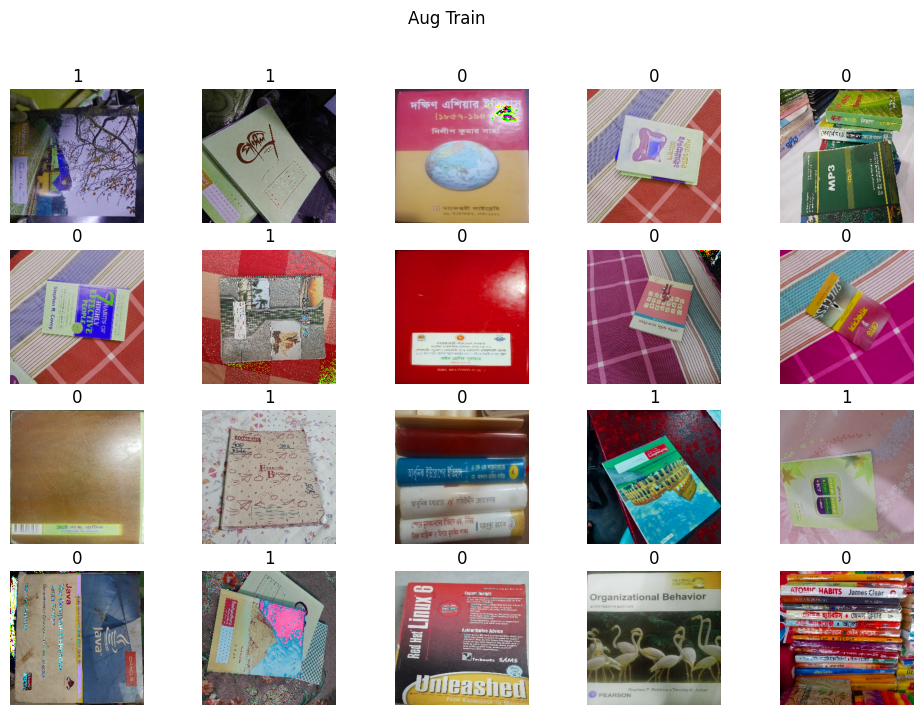

In [563]:
plot_images(aug_train, 'Aug Train')

# Merging the photometric augmented images to actual train and validation dataset

In [564]:
train_ds = train_ds.concatenate(aug_train)
val_ds = val_ds.concatenate(aug_val)

# Shuffling the datasets

In [565]:
train_ds = train_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
# val_ds = val_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)

In [566]:
# aug_train = aug_train.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
# plot_images(aug_train, 'Aug Train')

In [567]:
# plot_images(val_ds, 'Validation Dataset')

In [568]:
# plot_images(test_ds, 'Test Dataset')

In [569]:
# !pip install -q --upgrade keras-cv

In [570]:
# import keras_cv
# mix_up = keras_cv.layers.MixUp()
# cut_mix = keras_cv.layers.CutMix()

In [571]:
# def mix_up_f(images, labels):
#     labels = tf.one_hot(labels, 2)
#     labels = tf.cast(labels, tf.float32)
#     samples = {"images": images, "labels": labels}
#     samples = mix_up(samples, training=True)
#     return samples["images"], tf.cast(samples["labels"], tf.uint8)

In [572]:
# def cut_mix_f(images, labels):
#     labels = tf.one_hot(labels, 2)
#     labels = tf.cast(labels, tf.float32)
#     samples = {"images": images, "labels": labels}
#     samples = cut_mix(samples, training=True)
#     return samples["images"], tf.cast(samples["labels"], tf.uint8)

In [573]:
# def mix_up_cut_mix_augmentation(dataset):
#     mix_up_images = []
#     mix_up_labels = []

#     for images, labels in dataset:
#         labels = tf.argmax(labels, axis=-1)
#         labels = tf.cast(labels, tf.uint8)
#         images = tf.cast(images, tf.float16)
#         mix_up_images.append(images.numpy())
#         mix_up_labels.append(labels.numpy())

#     mix_up_images = np.concatenate(mix_up_images, axis=0)
#     mix_up_labels = np.concatenate(mix_up_labels, axis=0)
#     return tf.data.Dataset.from_tensor_slices((mix_up_images, mix_up_labels)).batch(batch_size)

In [574]:
# def mix_up_cut_mix(dataset, op):
#     ds=None
#     if op == "mix_up":
#         ds = dataset.map(lambda x, y : mix_up_f(x, y), num_parallel_calls=AUTOTUNE)
#     elif op == "cut_mix":
#         ds = dataset.map(lambda x, y : cut_mix_f(x, y), num_parallel_calls=AUTOTUNE)
#     return mix_up_cut_mix_augmentation(ds)

In [575]:
# mix_up_train = mix_up_cut_mix(tmp_train_ds, "mix_up")
# cut_mix_train = mix_up_cut_mix(tmp_train_ds, "cut_mix")

In [576]:
# mix_up_val = mix_up_cut_mix(tmp_val_ds, "mix_up")
# cut_mix_val = mix_up_cut_mix(tmp_val_ds, "cut_mix")

In [577]:
# plot_images(mix_up_train, 'Mix Up Dataset')

In [578]:
# plot_images(cut_mix_train, 'cut mix dataset')

In [579]:
# train_ds = train_ds.concatenate(mix_up_train)
# train_ds = train_ds.concatenate(cut_mix_train)

In [580]:
# val_ds = val_ds.concatenate(mix_up_val)
# val_ds = val_ds.concatenate(cut_mix_val)

In [581]:
# aug_train_cut_mix = mix_up_cut_mix(aug_train, "cut_mix")
# train_ds = train_ds.concatenate(aug_train_cut_mix)

In [582]:
# aug_val_cut_mix = mix_up_cut_mix(aug_val, "cut_mix")
# val_ds = val_ds.concatenate(aug_val_cut_mix)

In [583]:
# aug_train_mix_up = mix_up_cut_mix(aug_train, "mix_up")
# train_ds = train_ds.concatenate(aug_train_mix_up)

In [584]:
# aug_val_mix_up = mix_up_cut_mix(aug_val, "mix_up")
# val_ds = val_ds.concatenate(aug_val_mix_up)

In [585]:
# train_ds = train_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)
# val_ds = val_ds.shuffle(buffer_size=100000).prefetch(AUTOTUNE)

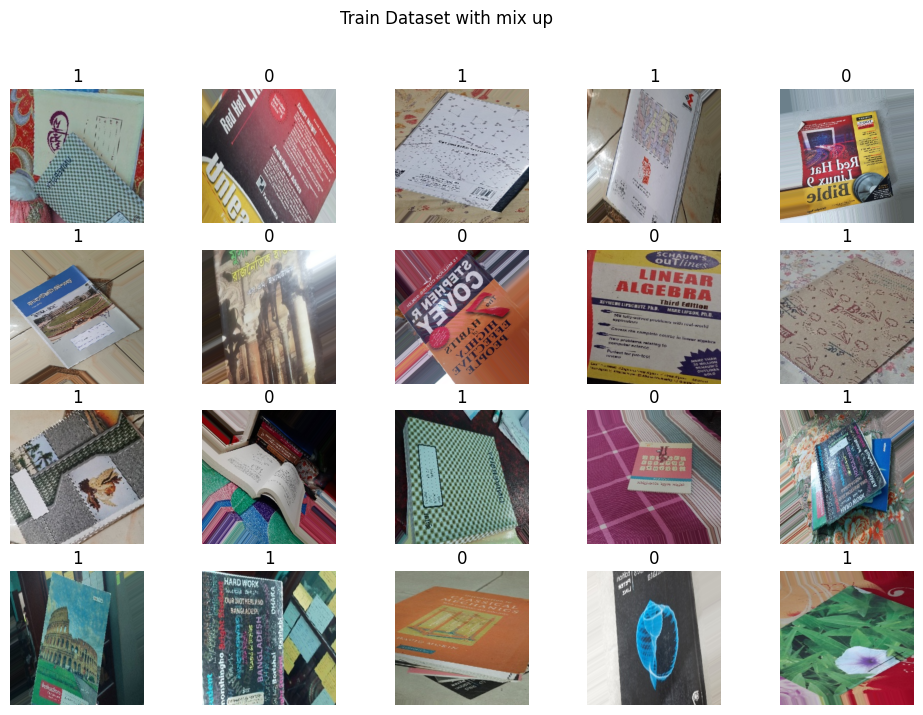

In [586]:
plot_images(train_ds, 'Train Dataset with mix up')

In [587]:
import gc
gc.collect()

126821

In [588]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

# FCNN Model

In [589]:
with strategy.scope():

    inputs = Input(shape=image_size + (3,))
    x = Flatten()(inputs)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    fc_model = keras.Model(inputs, outputs, name='FC_Model')
    fc_model.summary()
    
    fc_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(name='accuracy')]
    )

Model: "FC_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 256)            │    50,331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,808,449 (193.82 MB)

 Trainable params: 50,808,449 (193.82 MB)

 Non-trainable params: 0 (0.00 B)

In [590]:
class CustomLearningRateSchedule(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, decay_factor=0.1):
        super().__init__()
        self.initial_lr = initial_lr
        self.decay_factor = decay_factor

    def on_epoch_begin(self, epoch, logs=None):
            lr = self.model.optimizer.learning_rate
            lr = self.initial_lr * tf.exp(-self.decay_factor * epoch)
            self.model.optimizer.learning_rate = lr

In [591]:
# checkpoint_dir = './checkpoints'

# Training FCNN model

In [592]:
with strategy.scope():
#     tf.saved_model.save(fc_model, 'fc_model.keras', options=save_locally)

    history = fc_model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9, patience=3, verbose=1),
        #             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
                ModelCheckpoint('FC_Model.keras', save_weights_only=False, save_best_only=True, verbose=1),
                EarlyStopping(patience=15, restore_best_weights=True),
            ],
        )

Epoch 1/50


2024-07-26 14:47:38.670679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1722005259.330533     752 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(544f1a1586cd4b7b:0:0), session_name()


  7/209 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4469 - loss: 170.0492  

I0000 00:00:1722005343.694327     752 tpu_compile_op_common.cc:245] Compilation of 544f1a1586cd4b7b:0:0 with session name  took 1m24.363749085s and succeeded
I0000 00:00:1722005343.699427     752 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(544f1a1586cd4b7b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10412072376722128599", property.function_library_fingerprint = 662697850084659125, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722005343.699463     752 tpu_compilation_cache_interface.cc:541] After adding entry for key 5

 42/209 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4820 - loss: 202.0218

I0000 00:00:1722005344.696024     748 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(be39b1a84fd3d972:0:0), session_name()


 47/209 ━━━━━━━━━━━━━━━━━━━━ 2:30 929ms/step - accuracy: 0.4874 - loss: 199.0163

I0000 00:00:1722005386.308703     748 tpu_compile_op_common.cc:245] Compilation of be39b1a84fd3d972:0:0 with session name  took 41.612634855s and succeeded
I0000 00:00:1722005386.313208     748 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(be39b1a84fd3d972:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10412072376722128599", property.function_library_fingerprint = 662697850084659125, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722005386.313246     748 tpu_compilation_cache_interface.cc:541] After adding entry for key be3

208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5281 - loss: 150.3191

2024-07-26 14:49:53.688311: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.
I0000 00:00:1722005393.880735     785 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ca90b60d7b776df4:0:0), session_name()
I0000 00:00:1722005489.083383     785 tpu_compile_op_common.cc:245] Compilation of ca90b60d7b776df4:0:0 with session name  took 1m35.202599808s and succeeded
I0000 00:00:1722005489.085037     785 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ca90b60d7b776df4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13832624269436253", property.function_library_fingerprint = 3843191661325023659, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, top


Epoch 1: val_loss improved from inf to 140.44994, saving model to FC_Model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 282s 900ms/step - accuracy: 0.5283 - loss: 150.0265 - val_accuracy: 0.5000 - val_loss: 140.4499 - learning_rate: 1.0000e-04
Epoch 2/50
208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5930 - loss: 67.8026
Epoch 2: val_loss did not improve from 140.44994
209/209 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.5931 - loss: 67.6694 - val_accuracy: 0.5000 - val_loss: 218.0662 - learning_rate: 1.0000e-04
Epoch 3/50
207/209 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5739 - loss: 58.1979
Epoch 3: val_loss improved from 140.44994 to 43.42759, saving model to FC_Model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.5744 - loss: 57.9374 - val_accuracy: 0.4509 - val_loss: 43.4276 - learning_rate: 1.0000e-04
Epoch 4/50
208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6595 - loss: 30.6943
Epoch 4: val_loss improved from 43.42759 to 7.92248, saving model t

# FCNN graph comparisons

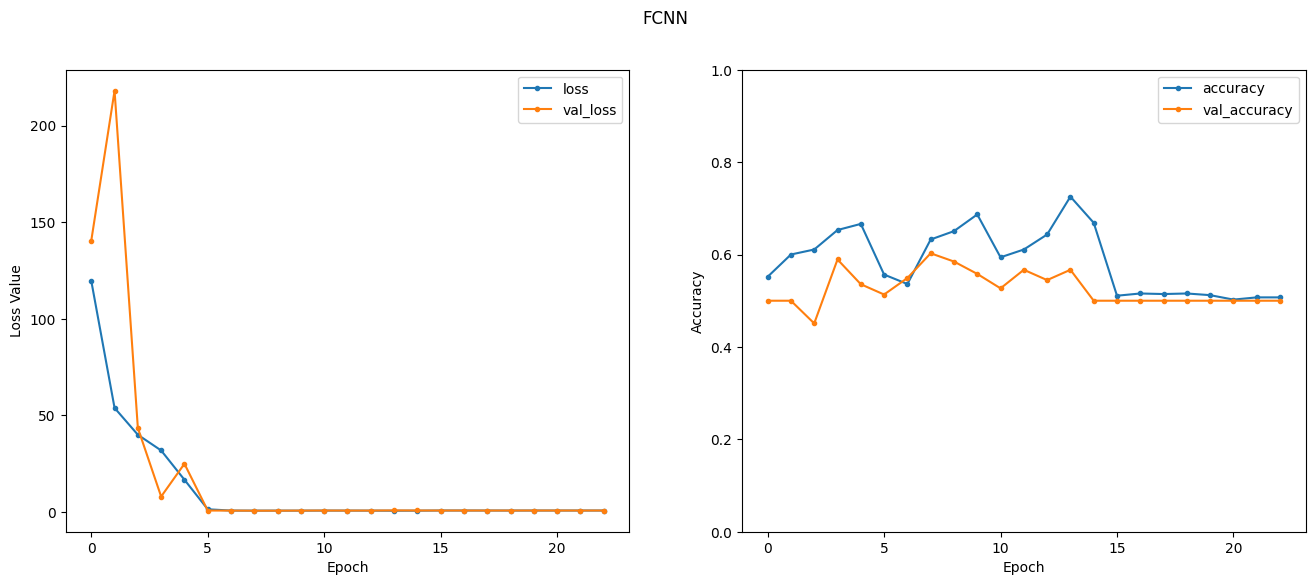

In [593]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('FCNN')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best FCNN checkpoints and compiling

In [594]:
with strategy.scope():

    fc_model = tf.keras.models.load_model('FC_Model.keras')

    fc_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating FCNN

In [595]:
with strategy.scope():

    eval = fc_model.evaluate(test_ds, return_dict=True)

    print(eval)

2024-07-26 14:57:17.801087: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722005838.073260     828 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(cce9791416e2a6ba:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 22ms/step - accuracy: 0.8750 - f1score: 0.1818 - loss: 0.6511 - precision: 0.3333 - recall: 0.1250           
{'accuracy': 0.75, 'f1score': 0.5454545021057129, 'loss': 0.5935827493667603, 'precision': 1.0, 'recall': 0.375}


I0000 00:00:1722005926.514567     828 tpu_compile_op_common.cc:245] Compilation of cce9791416e2a6ba:0:0 with session name  took 1m28.441256649s and succeeded
I0000 00:00:1722005926.516632     828 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(cce9791416e2a6ba:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5092522254391192267", property.function_library_fingerprint = 6387605683095471673, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722005926.516670     828 tpu_compilation_cache_interface.cc:541] After adding entry for key c

In [596]:
gc.collect()

244184

# SCNN model

In [597]:
with strategy.scope():
    inputs = Input(shape=image_size + (3,))
    x = Conv2D(filters=128, kernel_size=5, padding='same', activation='relu')(inputs)
    x = Conv2D(filters=128, kernel_size=5, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    cnn_model = Model(inputs, outputs, name='SCNN_Model')
    cnn_model.summary()
    
    cnn_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(name='accuracy')])

Model: "SCNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 256, 256, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 256, 256, 128)  │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,518,593 (40.13 MB)

 Trainable params: 10,518,593 (40.13 MB)

 Non-trainable params: 0 (0.00 B)

# Training SCNN model

In [598]:
with strategy.scope():
 
    history = cnn_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('SCNN_Model.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


2024-07-26 14:59:09.090115: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1722005949.786777     826 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(47cead52d5e1bd7f:0:0), session_name()


  4/209 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.3646 - loss: 1.6304  

I0000 00:00:1722005957.985347     826 tpu_compile_op_common.cc:245] Compilation of 47cead52d5e1bd7f:0:0 with session name  took 8.198512719s and succeeded
I0000 00:00:1722005957.993411     826 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(47cead52d5e1bd7f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1332958315332209050", property.function_library_fingerprint = 11006229964537034881, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722005957.993448     826 tpu_compilation_cache_interface.cc:541] After adding entry for key 47c

 86/209 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4495 - loss: 0.8795

I0000 00:00:1722005961.773114     830 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(61c0da7889af4793:0:0), session_name()


 89/209 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - accuracy: 0.4501 - loss: 0.8751

I0000 00:00:1722005974.198767     830 tpu_compile_op_common.cc:245] Compilation of 61c0da7889af4793:0:0 with session name  took 12.425593791s and succeeded
I0000 00:00:1722005974.208516     830 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(61c0da7889af4793:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1332958315332209050", property.function_library_fingerprint = 11006229964537034881, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722005974.208551     830 tpu_compilation_cache_interface.cc:541] After adding entry for key 61

208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4958 - loss: 0.7869

I0000 00:00:1722005983.658588     830 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c0a0277f39916d7b:0:0), session_name()
I0000 00:00:1722005988.679793     830 tpu_compile_op_common.cc:245] Compilation of c0a0277f39916d7b:0:0 with session name  took 5.021161581s and succeeded
I0000 00:00:1722005988.682879     830 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c0a0277f39916d7b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5687438905471771252", property.function_library_fingerprint = 16408672315481689456, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embeddi


Epoch 1: val_loss improved from inf to 0.72334, saving model to SCNN_Model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 66s 208ms/step - accuracy: 0.4963 - loss: 0.7862 - val_accuracy: 0.3973 - val_loss: 0.7233 - learning_rate: 1.0000e-04
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6474 - loss: 0.6395
Epoch 2: val_loss improved from 0.72334 to 0.67135, saving model to SCNN_Model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.6475 - loss: 0.6394 - val_accuracy: 0.5938 - val_loss: 0.6714 - learning_rate: 1.0000e-04
Epoch 3/50
208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6558 - loss: 0.6459
Epoch 3: val_loss did not improve from 0.67135
209/209 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.6559 - loss: 0.6458 - val_accuracy: 0.5223 - val_loss: 0.7719 - learning_rate: 1.0000e-04
Epoch 4/50
208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7044 - loss: 0.5808
Epoch 4: val_loss did not improve from 0.67135
209/209 ━━━━━━━━━━━━━━━━━━━━ 18s 60m

# SCNN graph comparisons

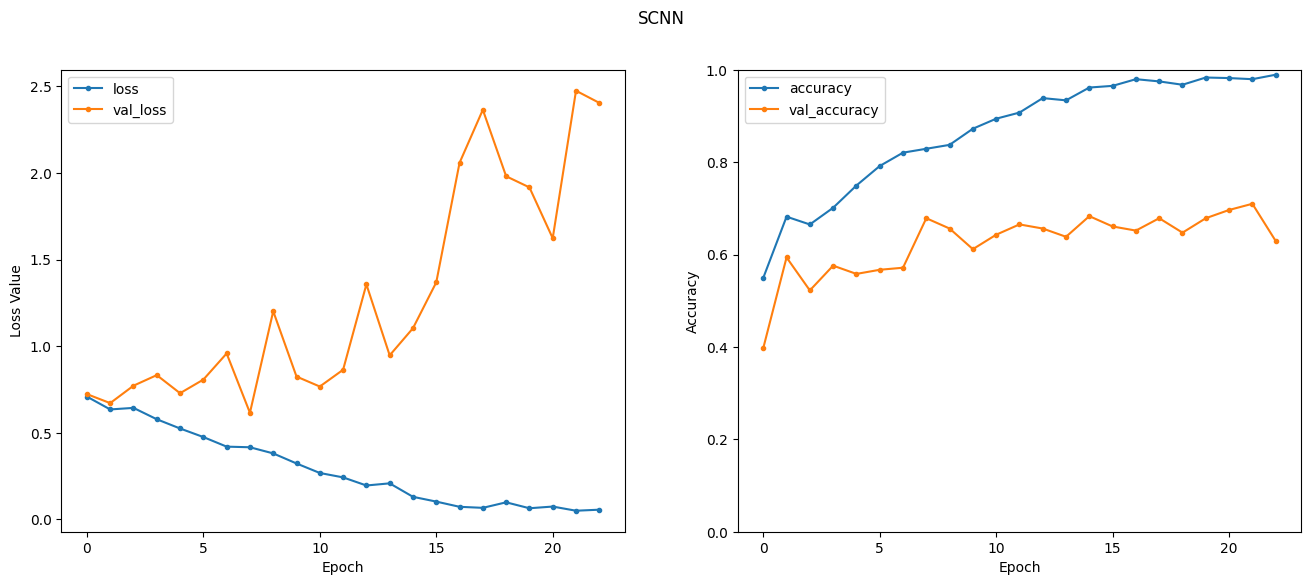

In [599]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('SCNN')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best SCNN checkpoints and compiling

In [600]:
with strategy.scope():
    
    cnn_model = tf.keras.models.load_model('SCNN_Model.keras')

    cnn_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating SCNN

In [601]:
with strategy.scope():
    
    eval = cnn_model.evaluate(test_ds, return_dict=True)

    print(eval)

2024-07-26 15:06:40.619597: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722006400.901007     749 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(186528f46ac3d4ed:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9292 - f1score: 0.3675 - loss: 0.3053 - precision: 0.5000 - recall: 0.2917          
{'accuracy': 0.8500000238418579, 'f1score': 0.7692307233810425, 'loss': 0.48248785734176636, 'precision': 1.0, 'recall': 0.625}


I0000 00:00:1722006405.935074     749 tpu_compile_op_common.cc:245] Compilation of 186528f46ac3d4ed:0:0 with session name  took 5.034027042s and succeeded
I0000 00:00:1722006405.938930     749 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(186528f46ac3d4ed:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8019151419227984784", property.function_library_fingerprint = 8271983792863987517, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722006405.938964     749 tpu_compilation_cache_interface.cc:541] After adding entry for key 1865

# VGG16 Model

In [602]:
with strategy.scope():

    vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=image_size+(3,))

    inputs = vgg16.input
    x = keras.layers.Flatten()(vgg16.output)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    vgg16_model = Model(inputs, outputs, name='VGG16_Model')
    vgg16_model.summary()
    
    vgg16_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy(name='accuracy')])

Model: "VGG16_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 23,136,577 (88.26 MB)

 Non-trainable params: 0 (0.00 B)

# Training VGG16(no weights) model

In [603]:
with strategy.scope():

    history = vgg16_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('VGG16_Model.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


I0000 00:00:1722006427.433555     795 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ba57908474c190b4:0:0), session_name()


  3/209 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2083 - loss: 1.9854    

I0000 00:00:1722006436.522032     795 tpu_compile_op_common.cc:245] Compilation of ba57908474c190b4:0:0 with session name  took 9.088431522s and succeeded
I0000 00:00:1722006436.531711     795 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ba57908474c190b4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_374341232709306855", property.function_library_fingerprint = 13057740609168250582, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722006436.531754     795 tpu_compilation_cache_interface.cc:541] After adding entry for key ba57

 25/209 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.3700 - loss: 1.2268

I0000 00:00:1722006437.558011     818 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(4e1d2564b4940e28:0:0), session_name()


 30/209 ━━━━━━━━━━━━━━━━━━━━ 55s 308ms/step - accuracy: 0.3777 - loss: 1.1680

I0000 00:00:1722006445.301930     818 tpu_compile_op_common.cc:245] Compilation of 4e1d2564b4940e28:0:0 with session name  took 7.743863875s and succeeded
I0000 00:00:1722006445.312127     818 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(4e1d2564b4940e28:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_374341232709306855", property.function_library_fingerprint = 13057740609168250582, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722006445.312167     818 tpu_compilation_cache_interface.cc:541] After adding entry for key 4e1d

208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4589 - loss: 0.8109

I0000 00:00:1722006457.029931     835 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a574dc637af692a3:0:0), session_name()
I0000 00:00:1722006463.849992     835 tpu_compile_op_common.cc:245] Compilation of a574dc637af692a3:0:0 with session name  took 6.82000899s and succeeded
I0000 00:00:1722006463.853466     835 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a574dc637af692a3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_496560655445044271", property.function_library_fingerprint = 14636582146152077483, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding


Epoch 1: val_loss improved from inf to 0.69423, saving model to VGG16_Model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 59s 163ms/step - accuracy: 0.4590 - loss: 0.8100 - val_accuracy: 0.3973 - val_loss: 0.6942 - learning_rate: 1.0000e-04
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5393 - loss: 0.6871
Epoch 2: val_loss did not improve from 0.69423
209/209 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.5393 - loss: 0.6871 - val_accuracy: 0.4330 - val_loss: 0.8468 - learning_rate: 1.0000e-04
Epoch 3/50
208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6133 - loss: 0.6681
Epoch 3: val_loss did not improve from 0.69423
209/209 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.6130 - loss: 0.6683 - val_accuracy: 0.4554 - val_loss: 0.7100 - learning_rate: 1.0000e-04
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5257 - loss: 0.6961
Epoch 4: val_loss improved from 0.69423 to 0.69344, saving model to VGG16_Model.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 19s 6

# VGG16(no weights) graph comparisons

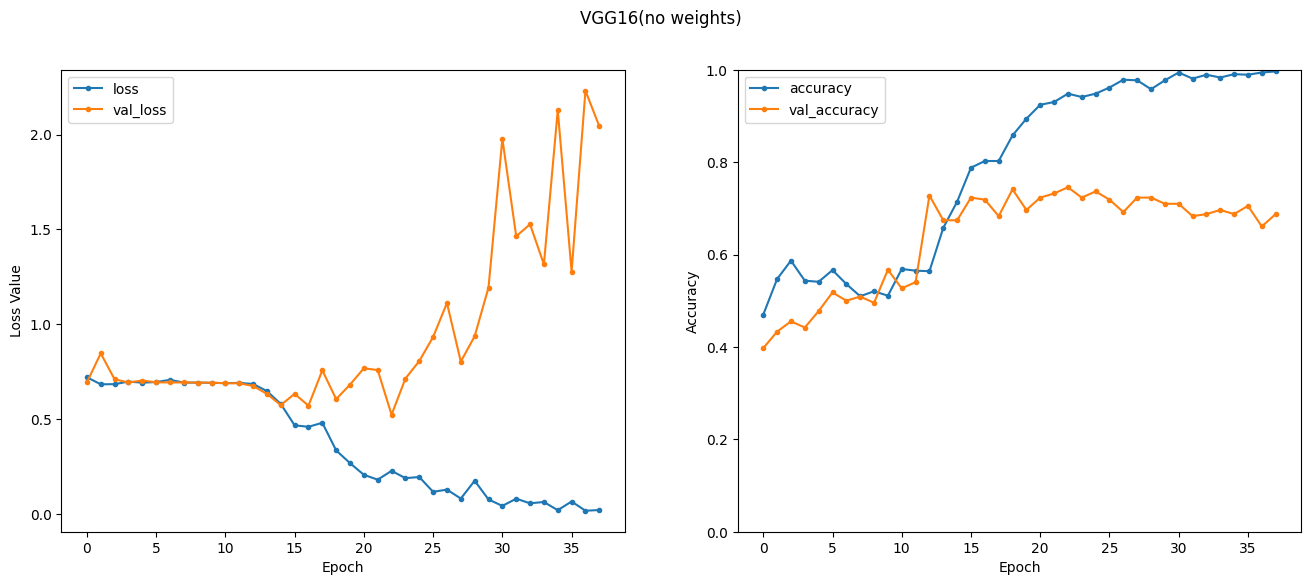

In [604]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('VGG16(no weights)')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best VGG16(no weights) checkpoints and compiling

In [605]:
with strategy.scope():
    
    vgg16_model = tf.keras.models.load_model('VGG16_Model.keras')

    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating VGG16(no weights)

In [606]:
with strategy.scope():
    
    eval = vgg16_model.evaluate(test_ds, return_dict=True)

    print(eval)

2024-07-26 15:18:41.445337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722007121.772747     815 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d80b893537017361:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8153 - f1score: 0.2937 - loss: 0.3364 - precision: 0.3611 - recall: 0.2500       


I0000 00:00:1722007128.612686     815 tpu_compile_op_common.cc:245] Compilation of d80b893537017361:0:0 with session name  took 6.839863032s and succeeded
I0000 00:00:1722007128.616822     815 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d80b893537017361:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14661029288416968038", property.function_library_fingerprint = 6695653721470010160, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722007128.616860     815 tpu_compilation_cache_interface.cc:541] After adding entry for key d80

{'accuracy': 0.800000011920929, 'f1score': 0.714285671710968, 'loss': 0.3775162696838379, 'precision': 0.8333333134651184, 'recall': 0.625}


# VGG16 with imagenet weights

In [607]:
with strategy.scope():

    vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=image_size+(3,))

    inputs = vgg16.input
    x = Flatten()(vgg16.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    vgg16_model = Model(inputs, outputs, name='VGG16_Model_Half_TL')
    vgg16_model.summary(show_trainable=True)
    
    base_vgg16_model = vgg16_model
    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(name='accuracy')]
    )

Model: "VGG16_Model_Half_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_25 (InputLayer) │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 256, 256, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 256, 256, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 128, 128, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 128, 128, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 128, 128, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 64, 64, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 64, 64, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 32, 32, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 16, 16, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 8, 8, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_25 (Flatten)        │ (None, 32768)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_102 (Dense)           │ (None, 256)           │  8,388,864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_103 (Dense)           │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_104 (Dense)           │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 23,136,577 (88.26 MB)

 Non-trainable params: 0 (0.00 B)

# Freezing all the layers except the last 4

In [608]:
with strategy.scope():

    for layer in vgg16_model.layers[:-4]:
      layer.trainable = False
    vgg16_model.summary(show_trainable=True)

Model: "VGG16_Model_Half_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_25 (InputLayer) │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 256, 256, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 256, 256, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 128, 128, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 128, 128, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 128, 128, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 64, 64, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 64, 64, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 32, 32, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 16, 16, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 8, 8, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_25 (Flatten)        │ (None, 32768)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_102 (Dense)           │ (None, 256)           │  8,388,864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_103 (Dense)           │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_104 (Dense)           │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 8,421,889 (32.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Apply Preprocessing Function
#### Since we are using pretrained weights, we need to preprocess our inputs with an appropiate preprocessing function. One way of doing this is to map the preprocessing function to the dataset object.

In [609]:
prep_train_ds = train_ds.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y))
prep_val_ds = val_ds.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y))
prep_test_ds = test_ds.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y))

# Training VGG16 with imagenet and freezed layers

In [610]:
with strategy.scope():

    history = vgg16_model.fit(
        prep_train_ds,
        validation_data=prep_val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('VGG16_Model_Half_TL.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


I0000 00:00:1722007143.133440     746 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b35fbd48abea921a:0:0), session_name()


  7/209 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5501 - loss: 3.4334 

I0000 00:00:1722007150.101764     746 tpu_compile_op_common.cc:245] Compilation of b35fbd48abea921a:0:0 with session name  took 6.968261824s and succeeded
I0000 00:00:1722007150.106692     746 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b35fbd48abea921a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14714529666035645307", property.function_library_fingerprint = 3886468010787766313, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722007150.106728     746 tpu_compilation_cache_interface.cc:541] After adding entry for key b35

 73/209 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6707 - loss: 2.1461

I0000 00:00:1722007151.827250     798 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ecb94afc1f28e1a9:0:0), session_name()


 83/209 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.6839 - loss: 2.0500

I0000 00:00:1722007156.206141     798 tpu_compile_op_common.cc:245] Compilation of ecb94afc1f28e1a9:0:0 with session name  took 4.378849358s and succeeded
I0000 00:00:1722007156.211074     798 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ecb94afc1f28e1a9:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14714529666035645307", property.function_library_fingerprint = 3886468010787766313, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722007156.211104     798 tpu_compilation_cache_interface.cc:541] After adding entry for key ecb

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7673 - loss: 1.4811

I0000 00:00:1722007163.239513     805 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(95bbe397b99dca1:0:0), session_name()
I0000 00:00:1722007170.029540     805 tpu_compile_op_common.cc:245] Compilation of 95bbe397b99dca1:0:0 with session name  took 6.78996565s and succeeded
I0000 00:00:1722007170.032861     805 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(95bbe397b99dca1:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5354261420160476145", property.function_library_fingerprint = 10521271154579008808, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_p


Epoch 1: val_loss improved from inf to 1.60709, saving model to VGG16_Model_Half_TL.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.7677 - loss: 1.4789 - val_accuracy: 0.8170 - val_loss: 1.6071 - learning_rate: 1.0000e-04
Epoch 2/50
207/209 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9781 - loss: 0.1009
Epoch 2: val_loss did not improve from 1.60709
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.9781 - loss: 0.1013 - val_accuracy: 0.7723 - val_loss: 3.7258 - learning_rate: 1.0000e-04
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9834 - loss: 0.0752
Epoch 3: val_loss did not improve from 1.60709
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.9834 - loss: 0.0753 - val_accuracy: 0.8348 - val_loss: 1.6289 - learning_rate: 1.0000e-04
Epoch 4/50
207/209 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.999999772640876e-05.

Epoch 4: val_loss did not improve f

# VGG16 with imagenet and freezed layers graph comparisons

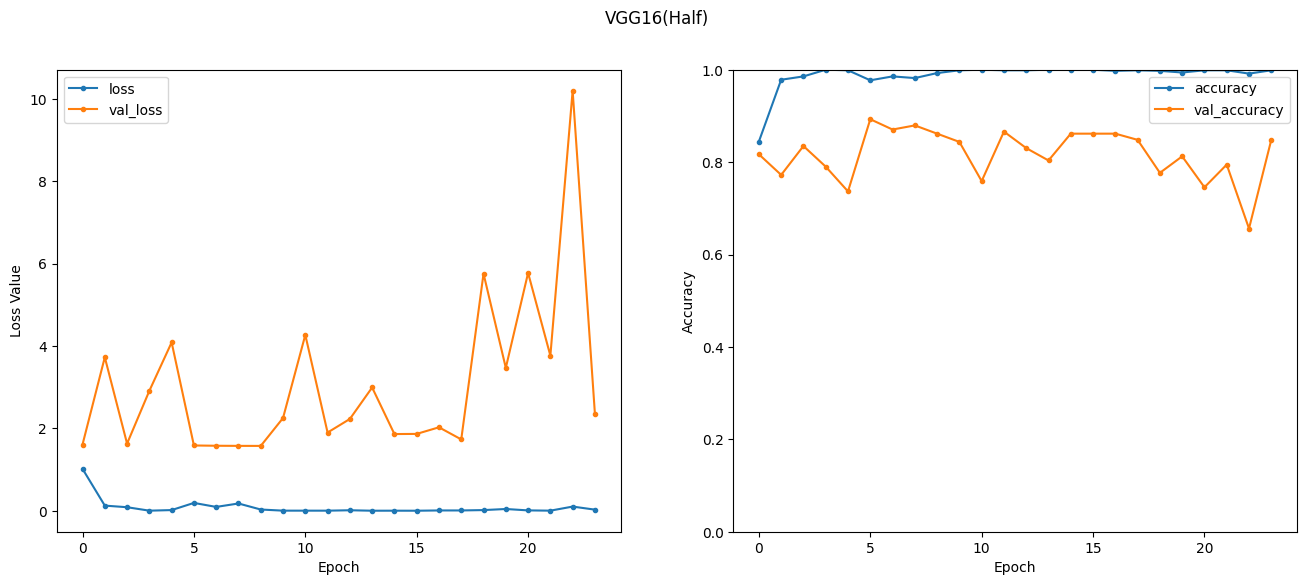

In [611]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('VGG16(Half)')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

# Loading best VGG16 with imagenet and freezed layers checkpoints and compiling

In [612]:
with strategy.scope():
    
    vgg16_model = tf.keras.models.load_model('VGG16_Model_Half_TL.keras')

    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating VGG16 with imagenet and freezed layers

In [613]:
with strategy.scope():
    
    eval = vgg16_model.evaluate(prep_test_ds, return_dict=True)

    print(eval)

2024-07-26 15:25:06.754893: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722007507.103961     779 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(4651280dc1112117:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8694 - f1score: 0.4167 - loss: 0.4237 - precision: 0.4167 - recall: 0.4167         
{'accuracy': 0.8999999761581421, 'f1score': 0.8749999403953552, 'loss': 0.3854048252105713, 'precision': 0.875, 'recall': 0.875}


I0000 00:00:1722007513.608563     779 tpu_compile_op_common.cc:245] Compilation of 4651280dc1112117:0:0 with session name  took 6.504521333s and succeeded
I0000 00:00:1722007513.612953     779 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(4651280dc1112117:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16463123264368006808", property.function_library_fingerprint = 921318246298749388, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722007513.612987     779 tpu_compilation_cache_interface.cc:541] After adding entry for key 4651

# Unfreezing all the layers and train them all

In [614]:
with strategy.scope():

    for layer in vgg16_model.layers:
      layer.trainable = True
    vgg16_model.summary(show_trainable=True)

Model: "VGG16_Model_Half_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_25 (InputLayer) │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 256, 256, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 256, 256, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 128, 128, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 128, 128, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 128, 128, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 64, 64, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 64, 64, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 32, 32, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 16, 16, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 8, 8, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_25 (Flatten)        │ (None, 32768)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_102 (Dense)           │ (None, 256)           │  8,388,864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_103 (Dense)           │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_104 (Dense)           │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,136,577 (88.26 MB)

 Trainable params: 23,136,577 (88.26 MB)

 Non-trainable params: 0 (0.00 B)

# Training VGG16(FULL) model

In [615]:
with strategy.scope():

    base_vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[BinaryAccuracy(name='accuracy')]
    )
    
    history = base_vgg16_model.fit(
        prep_train_ds,
        validation_data=prep_val_ds,
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
#             CustomLearningRateSchedule(decay_factor=lr_decay_factor, initial_lr=learning_rate),
            ModelCheckpoint('VGG16_Model_Full_TL.keras', save_weights_only=False, save_best_only=True, verbose=1),
            EarlyStopping(patience=15, restore_best_weights=True),
        ],
    )

Epoch 1/50


I0000 00:00:1722007527.064470     815 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b22af91516f00764:0:0), session_name()


  7/209 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 1.0000 - loss: 1.9961e-05 

I0000 00:00:1722007533.645853     815 tpu_compile_op_common.cc:245] Compilation of b22af91516f00764:0:0 with session name  took 6.581330287s and succeeded
I0000 00:00:1722007533.650785     815 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b22af91516f00764:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4030932713798183854", property.function_library_fingerprint = 1213707842355595939, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722007533.650821     815 tpu_compilation_cache_interface.cc:541] After adding entry for key b22a

 49/209 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9974 - loss: 0.0071

I0000 00:00:1722007534.807667     824 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(49084a0a8d8ed7f5:0:0), session_name()


 57/209 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.9971 - loss: 0.0077

I0000 00:00:1722007539.200421     824 tpu_compile_op_common.cc:245] Compilation of 49084a0a8d8ed7f5:0:0 with session name  took 4.392714301s and succeeded
I0000 00:00:1722007539.205374     824 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(49084a0a8d8ed7f5:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4030932713798183854", property.function_library_fingerprint = 1213707842355595939, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722007539.205405     824 tpu_compilation_cache_interface.cc:541] After adding entry for key 4908

208/209 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9969 - loss: 0.0091
Epoch 1: val_loss improved from inf to 5.56951, saving model to VGG16_Model_Full_TL.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9969 - loss: 0.0091 - val_accuracy: 0.7902 - val_loss: 5.5695 - learning_rate: 1.0000e-04
Epoch 2/50
207/209 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9908 - loss: 0.0658
Epoch 2: val_loss improved from 5.56951 to 3.02427, saving model to VGG16_Model_Full_TL.keras
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.9908 - loss: 0.0660 - val_accuracy: 0.8661 - val_loss: 3.0243 - learning_rate: 1.0000e-04
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9877 - loss: 0.2265
Epoch 3: val_loss did not improve from 3.02427
209/209 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.9877 - loss: 0.2267 - val_accuracy: 0.8527 - val_loss: 3.2226 - learning_rate: 1.0000e-04
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9920 - loss

# VGG16(Full) graph comparisons

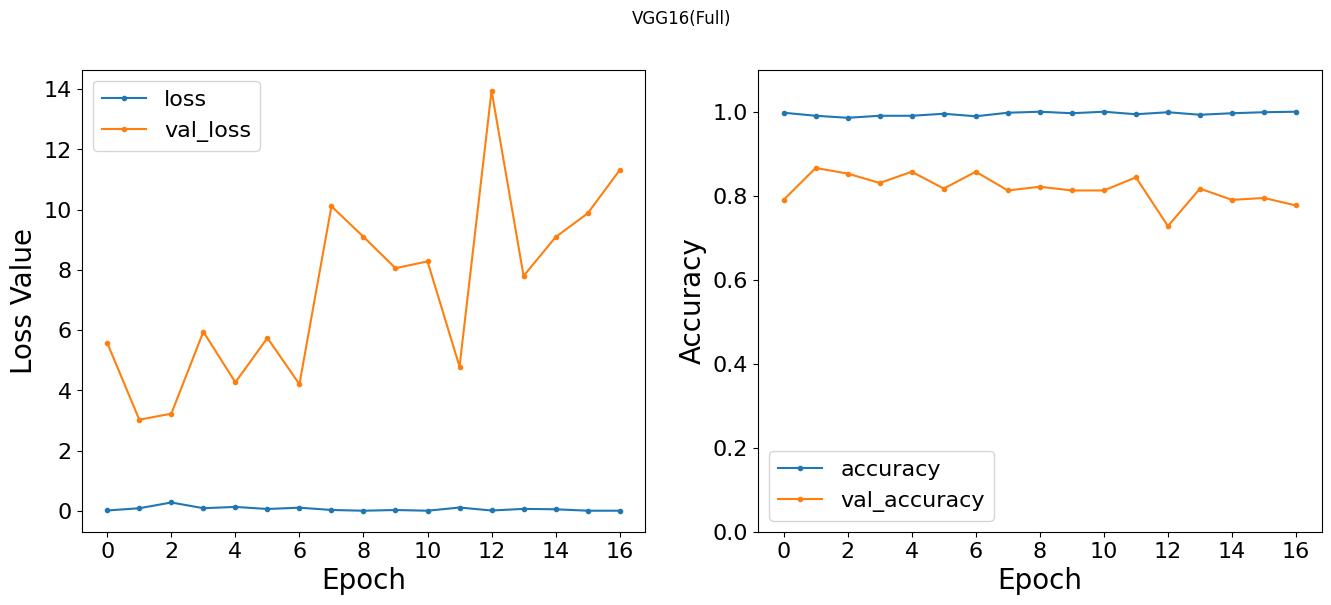

In [616]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.suptitle('VGG16(Full)')
plt.plot(history.history['loss'], '.-')
plt.plot(history.history['val_loss'], '.-')
plt.xlabel('Epoch', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Loss Value',fontsize=20)
plt.yticks(fontsize=16)
plt.legend(['loss', 'val_loss'],fontsize=16)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], '.-')
plt.plot(history.history['val_accuracy'], '.-')
plt.xlabel('Epoch',fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Accuracy',fontsize=20)
plt.yticks(fontsize=16)
plt.ylim([0, 1.1])
plt.legend(['accuracy', 'val_accuracy'],fontsize=16)

# plt.savefig("./{}.eps".format('vgg-c-2'), bbox_inches='tight', format='eps', dpi=1000)
plt.show()

# Loading best VGG16(Full) checkpoints and compiling

In [617]:
with strategy.scope():
    
    vgg16_model = tf.keras.models.load_model('VGG16_Model_Full_TL.keras')

    vgg16_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=[
            BinaryAccuracy(name='accuracy'),
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1score'),
        ]
    )

# Evaluating VGG16(Full)

In [618]:
with strategy.scope():
    
    eval = vgg16_model.evaluate(prep_test_ds, return_dict=True)

    print(eval)

2024-07-26 15:29:27.781148: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add_12/ReadVariableOp.
I0000 00:00:1722007768.169719     814 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2a2e320145c6d519:0:0), session_name()


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8694 - f1score: 0.4167 - loss: 4.4867 - precision: 0.4167 - recall: 0.4167            
{'accuracy': 0.8999999761581421, 'f1score': 0.8749999403953552, 'loss': 2.9107508659362793, 'precision': 0.875, 'recall': 0.875}


I0000 00:00:1722007774.825651     814 tpu_compile_op_common.cc:245] Compilation of 2a2e320145c6d519:0:0 with session name  took 6.655877278s and succeeded
I0000 00:00:1722007774.829373     814 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2a2e320145c6d519:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_3166673777249151992", property.function_library_fingerprint = 17158832002338943809, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,256,256,3,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722007774.829413     814 tpu_compilation_cache_interface.cc:541] After adding entry for key 2a2